# CycleNER

[Original Paper](https://dl.acm.org/doi/10.1145/3485447.3512012) by Andrea Iovine, Anjie Fang, Besnik Fetahu, Oleg Rokhlenko, Shervin Malmasi

Attempting to implement CycleNER to evaluate unsupervised learning of custom set of NER tags in National Gallery dataset.

CycleNER uses cycle-consistency training for two functions: sequence-to-entity (S2E); and entity-to-sequence (E2S), to learn NER tags from some seed set of sentences and another set of entity examples. The output from one function is the input the the other and the algorithm attempts to align each representation space, thus, learning to tag named entities in an unsupervised manner.

![CycleNER diagram](./cycle_ner_diagram.png)

### Import Modules

Import relevant libraries and packages

In [1]:
import json, os, torch, re, gc
import torch.optim as optim
from tqdm import tqdm
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration
from nltk.tokenize.treebank import TreebankWordDetokenizer
import pandas as pd
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support
import torch.nn.functional as F

# Ensures that all dataframes are displayed on one line instead of breaking columns across multiple lines
pd.set_option('display.expand_frame_repr', False)

### Import T5 Tokeniser

Import T5 tokenizer class and set the chosen device. Also setup any special tokeniser configuration

In [2]:
MODEL_MAX_LENGTH = 128

device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = T5Tokenizer.from_pretrained("t5-small", model_max_length=MODEL_MAX_LENGTH)

# Add special separator token
sep_token = '|'
tokenizer.sep_token = sep_token

print(tokenizer.sep_token, tokenizer.sep_token_id)

| 9175


### Import Data

Import CoNLL2003 dataset to recreate paper with

In [3]:
dataset = load_dataset("conll2003")
print(dataset['train'])

Found cached dataset conll2003 (/home/william/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})


Split the train, val and test set out into separate variables to manage them easier

In [4]:
train = dataset['train']
val   = dataset['validation']
test  = dataset['test']

Define a function to merge the BIO tagging scheme into a compound scheme

In [5]:
# Tag list taken from https://huggingface.co/datasets/conll2003
tag_to_idx = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
tag_to_string = {'PER': 'person', 'ORG': 'organisation', 'LOC': 'location', 'MISC': 'miscellaneous'}
string_to_tag = {string: tag for tag, string in tag_to_string.items()}

def combine_bio_tags(tokens, tags):
    compound_tokens = []

    for token, tag in zip(tokens, tags):
        if tag in [1, 3, 5, 7]:
            compound_tokens.append([token, sep_token, f"{tag_to_string[idx_to_tag[tag].split('-')[-1]]}"])
        elif tag in [2, 4, 6, 8]:
            compound_tokens[-1][-2:-2] = [token]
    
    return [' '.join(token_tags) for token_tags in compound_tokens]

Detokenise sentences and create expected output form T5 model using the 'tokens' and 'ner_tags' arrays

In [7]:
PREFIX = 'Detect tags: '

# Process all the relevant training data into dataframes to make manipulation easier
processed_sets = [pd.DataFrame(data={
        'prefix': PREFIX,
        'tokens': [TreebankWordDetokenizer().detokenize(x['tokens']) for x in set],
        'tags': [f' {sep_token} '.join(combine_bio_tags(x['tokens'], x['ner_tags'])) for x in set]
        }) for set in [train, val, test]]

train_df, val_df, test_df = processed_sets
train_df.sample(10).tags

12886    Venezuelan | miscellaneous | Luis Raul Matos A...
1536                   Bonn | location | Moscow | location
2381         Natalia Voronova | person | Russia | location
9381                                      PARIS | location
4659                                  SHEFFIELD | location
2572                             S.AFRICAN | miscellaneous
1608                                                      
5263     Parramatta | organisation | Sydney Tigers | or...
2114                               ST LOUIS | organisation
412           Dalglish | person | Blackburn | organisation
Name: tags, dtype: object

In [9]:
train_df.sample(10)[['tokens', 'tags']]

,tokens,tags
1044,The Richmond-based retailer lost $95.7 million...,Richmond-based | miscellaneous
2104,NATIONAL LEAGUE,NATIONAL LEAGUE | miscellaneous
11706,"Israeli travel restrictions, imposed after bom...",Israeli | miscellaneous | Moslem | miscellaneo...
850,The Mariners scored four runs in the top of th...,Mariners | organisation | Ripken | person | St...
12083,HONG KONG 1996-08-28,HONG KONG | location
6647,It said the row started when Popov and a group...,Popov | person
13475,The paper said Baker declined to discuss the t...,Baker | person
9666,They told reporters a group of Kurdistan Worke...,Kurdistan Workers Party | organisation | PKK |...
2200,BONN 1996-08-23,BONN | location
12707,Ajax defender John Veldman and his team mate R...,Ajax | organisation | John Veldman | person | ...


In [32]:
from itertools import chain, zip_longest

a = [1] * 10
b = ['a'] * 5

c = [x for x in chain.from_iterable(zip_longest(a, b)) if x is not None]

for i in range(len(a) + len(b)):
    print(c[i])

1
a
1
a
1
a
1
a
1
a
1
1
1
1
1


In [39]:
from tqdm import tqdm
a = [1] * 10

b = iter(a)

1
1


Define generic functions to process data in each dataset

In [7]:
def tokenise_func(examples):
    return tokenizer(
        examples,
        padding='max_length',
        truncation=True,
        max_length=MODEL_MAX_LENGTH,
        return_tensors='pt',
        )

# Replace all model pad tokens with -100 to be ignored in loss calculation by PyTorch
def replace_pad_tokens(examples):
    examples[examples==tokenizer.pad_token_id] = -100
    return examples

Create dataset from dataframe and encode the inputs and expected outputs for each element

In [8]:
dataset = Dataset.from_dict({
    'encode': list(train_df['prefix'] + train_df['tokens']),
    'encode_targets': list(train_df['tags'])
    })

# Process relevant columns in dataset ready for training
dataset = dataset.map(
    lambda batch: (tokenised := tokenise_func(batch['encode']), {'input_ids': tokenised.input_ids, 'attention_mask': tokenised.attention_mask})[-1],
    remove_columns=['encode'],
    batched=True
    )

dataset = dataset.map(
    lambda batch: {'labels': replace_pad_tokens(tokenise_func(batch['encode_targets']).input_ids)},
    remove_columns=['encode_targets'],
    batched=True
    )

# Shuffle dataset
dataset = dataset.shuffle(seed=42)
dataset.set_format(type='torch')
print(dataset)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 14041
})


### T5 as a tool for NER

Here we train T5 over just a few epochs to evaluate performance on traditional NER

In [9]:
EPOCHS = 5
BATCH_SIZE = 32
S2E_LEARNING_RATE = 1e-5 # 1e-4 was too high

s2e = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
s2e_optimiser = optim.AdamW(s2e.parameters(), lr=S2E_LEARNING_RATE)
s2e_losses = []

for epoch in range(EPOCHS):
    # Shuffle dataset
    dataset = dataset.shuffle(seed=42)

    # iterate over each mini_batch of BATCH_SIZE
    for i in tqdm(range(0, len(dataset), BATCH_SIZE)):
        # Fetch current batch
        try:
            mini_batch = dataset.select(range(i, i+BATCH_SIZE))
        except IndexError:
            mini_batch = dataset.select(range(i, len(dataset)))
        
        # Conduct training step for s2e model
        s2e_loss = s2e(
            input_ids      = mini_batch['input_ids'].to(device),
            attention_mask = mini_batch['attention_mask'].to(device),
            labels         = mini_batch['labels'].to(device)
            ).loss

        # Update s2e w.r.t. loss
        s2e_losses.append(s2e_loss.item())
        s2e_loss.backward()
        s2e_optimiser.step()

# Clear CUDA cache and dispose of useless data
torch.cuda.empty_cache()
gc.collect()

100%|██████████| 439/439 [01:36<00:00,  4.53it/s]


443

Plot the loss from training

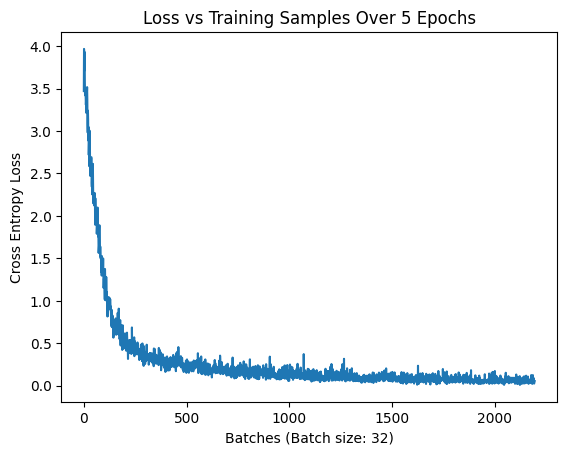

Final Loss: 0.05536260828375816


In [10]:
plt.plot(s2e_losses)
plt.title(f'Loss vs Training Samples Over {EPOCHS} Epochs')
plt.xlabel(f'Batches (Batch size: {BATCH_SIZE})')
plt.ylabel(f'Cross Entropy Loss')
plt.show()

print(f'Final Loss: {s2e_losses[-1]}')

Visually evaluate performance over a few test examples. As the examples show, the model is depending heavily on the capitalisation of entities to determine whether they are a named entity. The model cannot detect names if they are not capitalised which means more, randomly capitalised/lower-cased examples may improve performance.

In [17]:
test_inputs = [
        'NER Tag: The man from Germany walked his dog in the park.',
        'NER Tag: One year, a castle appeared upon the hill outside Bath.',
        'NER Tag: alan shearer was from newcastle. He played football there.',
        'NER Tag: Alan Shearer was from Newcastle. He played football there.',
        'NER Tag: Everybody knew that apple increased their prices, even bill.',
        'NER Tag: Everybody knew that Apple increased their prices, even Bill.'
        ]

encoded_inputs = tokenizer(
        test_inputs,
        padding='max_length',
        truncation=True,
        max_length=MODEL_MAX_LENGTH,
        return_tensors='pt'
        )

encoded_outputs = s2e.generate(input_ids=encoded_inputs.input_ids.to(device), attention_mask=encoded_inputs.attention_mask.to(device), max_length=MODEL_MAX_LENGTH)
pprint(tokenizer.batch_decode(encoded_outputs, skip_special_tokens=True))

['Germany [LOC]',
 'Bath [LOC]',
 '',
 'Alan Shearer [PER] Newcastle [LOC]',
 '',
 'Apple [ORG] Bill [PER]']


Test the performance of system against the test set

In [13]:
test_dataset = Dataset.from_dict({
    'encode': list(test_df['prefix'] + test_df['tokens']),
    'encode_targets': list(test_df['tags'])
    })

test_dataset = test_dataset.map(
    lambda batch: (tokenised := tokenise_func(batch['encode']), {'input_ids': tokenised.input_ids, 'attention_mask': tokenised.attention_mask})[-1],
    remove_columns=['encode'],
    batched=True
    )

test_dataset = test_dataset.map(
    lambda batch: {'labels': batch['encode_targets']},
    remove_columns=['encode_targets'],
    batched=True
    )

test_dataset = test_dataset.shuffle(seed=42)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

encoded_outputs = []
for i in tqdm(range(0, len(test_dataset), BATCH_SIZE)):
    # Fetch current batch
    try:
        mini_batch = test_dataset.select(range(i, i+BATCH_SIZE))
    except IndexError:
        mini_batch = test_dataset.select(range(i, len(test_dataset)))

    encoded_outputs.extend(s2e.generate(
        input_ids      = mini_batch['input_ids'].to(device),
        attention_mask = mini_batch['attention_mask'].to(device),
        max_length     = 128
        ))

decoded_outputs = tokenizer.batch_decode(encoded_outputs, skip_special_tokens=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

100%|██████████| 108/108 [00:38<00:00,  2.80it/s]


Evaluate performance of quickly trained T5 model using the test set. Evaluate using micro f1, precision and recall.

In [52]:
# Process labels into array of tagged terms
y_true = list(map(lambda x: re.findall(r'\S.*?\[.*?\]', x), test_dataset['labels']))
y_pred = list(map(lambda x: re.findall(r'\S.*?\[.*?\]', x), decoded_outputs))

binarizer = MultiLabelBinarizer()
# Fit to both sets to include all classes form training data
# https://stackoverflow.com/questions/72060723/i-am-having-a-userwarning-unknown-classes-when-using-multilabelbinarizer
binarizer.fit(y_true + y_pred)

precision, recall, f1, _ = precision_recall_fscore_support(
    binarizer.transform(y_true), 
    binarizer.transform(y_pred), 
    average='micro'
    )

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F-1: {f1}')


Precision: 0.8307495896407077
Recall: 0.8157234957020058
F-1: 0.8231679768681667


### Cycle Consistency Training

Define a training method which alternates between S-cycle training and E-cycle training. S-cycle loss is calculated as the reconstruction loss (avg. cross-entropy loss) of input $S$ and generated $S'$ where $S = \{s_1, s_2, \dots, s_n\}$ is the set of sentences containing zero or more entities:

$$
\mathcal{L_{\phi}}(S, S') = - \frac{\sum_{s \in S} \sum_{i < |s|}{p(s_i) log \space g(s'_i)}}{|s| * |S|}
$$

The loss function is identical for E-cycle training except for $S$ is replaced with $Q$, i.e. $\mathcal{L_{\theta}}(Q, Q')$ where $Q = \{< e_{1,1}, \dots, e_{1, k} >, \dots, < e_{m,1}, \dots, e_{m, l} > \}$ is the set of entity sequences containing zero or more entities.

First define a generic method for both the S- and E- cycles:

In [8]:
def cycle(input_ids, label_ids, generator_model, training_model, prefix_ids):
    '''
    Generic cycle function which performs each stage for S or E cycle. The behaviour of each
    cycle is, hence, defined:
        S-Cycle:
            1) From "NER Tag: <seed sentence>", generate entity sequence
            2) From generated entity sequence, generate something that resembles seed sentence
        
        E-Cycle:
            1) From "NER Tag: <seed entity sequence>", generate a sentence
            2) From generated sentence, generate an entity sequence that resembles seed entity sequence
    '''
    # zero the gradients
    generator_model.zero_grad()
    training_model.zero_grad()
    
    input_prime_ids = generator_model.generate(
        input_ids      = input_ids.to(device),
        max_length     = MODEL_MAX_LENGTH      
    )

    # Skip decode -> re-encode by removing leading pad and generating an attention mask
    input_prime_ids = input_prime_ids[:, 1:]

    # Insert prefix ids into sequence for training model
    input_prime_ids = torch.cat((prefix_ids.to(device).repeat(input_prime_ids.size(0), 1), input_prime_ids.to(device)), dim=1)

    # Create attention mask
    attention_mask = input_prime_ids.clone()
    attention_mask[attention_mask != 0] = 1

    # Set pad tokens to be ignored by PyTorch loss function
    label_ids[label_ids==tokenizer.pad_token_id] = -100
    
    loss = training_model(
        input_ids      = input_prime_ids.to(device),
        attention_mask = attention_mask.to(device),
        labels         = label_ids.to(device)
    ).loss
    
    return loss

Construct datasets for the task

In [ ]:
tokenizer.model

In [9]:
# Randomly pull out 20% of samples for pre-training
pre_train_df = train_df.sample(n=100)        # Used in fully supervised learning
train_df = train_df.drop(pre_train_df.index) # Used in CycleNER fine-tuning

def build_dataset(df, primary_key, secondary_key):
    return Dataset.from_dict({
        'text': list(df['prefix'] + df[primary_key]),
        'labels': list(df[secondary_key])
        }).map(
            lambda x: (tokenised_input := tokenise_func(x['text']), {
                'input_ids': tokenised_input.input_ids,
                'attention_mask': tokenised_input.attention_mask,
                'label_ids': tokenise_func(x['labels']).input_ids
                })[-1],
            batched=True)

# Build train datasets
s2e_pretrain = build_dataset(pre_train_df, 'tokens', 'tags')
s2e_train = build_dataset(train_df, 'tokens', 'tokens')
e2s_pretrain = build_dataset(pre_train_df, 'tags', 'tokens')
e2s_train = build_dataset(train_df, 'tags', 'tags')

# Build val datasets
s2e_val = build_dataset(val_df, 'tokens', 'tags')
e2s_val = build_dataset(val_df, 'tags', 'tokens')


all_datasets = [s2e_pretrain, s2e_train, e2s_pretrain, e2s_train, s2e_val, e2s_val]

for dataset in all_datasets:
    dataset.set_format(type='torch', columns=['input_ids', 'label_ids', 'attention_mask'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Use some supervised learning to pre-train each model the expected output format

In [2]:
a = [1] * 20
b = [2] * 5

b

[2, 2, 2, 2, 2]

In [13]:
EPOCHS = 5
BATCH_SIZE = 32
S2E_LEARNING_RATE = 1e-4
E2S_LEARNING_RATE = 1e-4

s2e = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
e2s = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
s2e_optimiser = optim.AdamW(s2e.parameters(), lr=S2E_LEARNING_RATE)
e2s_optimiser = optim.AdamW(e2s.parameters(), lr=E2S_LEARNING_RATE)

Define an evaluation method

In [14]:
def evaluate(model, eval_dataset, batch_size=32, calculate_f1=False):
    model.eval()
    running_loss = 0

    # Shuffle eval dataset
    dataset.shuffle(seed=42)
    batch_idxs = [list(range(len(eval_dataset)))[i:i+batch_size] for i in range(0, len(eval_dataset), batch_size)]

    generated_outputs = []

    for idxs in (pbar := tqdm(batch_idxs)):
        pbar.set_description('Evaluating')

        # Fetch current batch
        mini_batch = eval_dataset.select(idxs)

        label_ids = mini_batch['label_ids']
        label_ids[label_ids==tokenizer.pad_token_id] = -100
        
        # Conduct training step for s2e model
        loss = model(
            input_ids      = mini_batch['input_ids'].to(device),
            attention_mask = mini_batch['attention_mask'].to(device),
            labels         = label_ids.to(device)
            ).loss

        if calculate_f1:
            generated_output = model.generate(
                input_ids  = mini_batch['input_ids'].to(device),
                max_length = MODEL_MAX_LENGTH
                )

            generated_outputs.extend(F.pad(generated_output, (MODEL_MAX_LENGTH - generated_output.size(1), 0)))

        running_loss += loss.item()
        
    if calculate_f1:
        #print(generated_outputs)
        decoded_outputs = tokenizer.batch_decode(generated_outputs, skip_special_tokens=True)

        # Process labels into array of tagged terms
        y_true = list(map(lambda x: [' | '.join(x_i) for x_i in zip(x.split(' | ')[0::2], x.split(' | ')[1::2])], eval_dataset['labels']))
        y_pred = list(map(lambda x: [' | '.join(x_i) for x_i in zip(x.split(' | ')[0::2], x.split(' | ')[1::2])], decoded_outputs))

        binarizer = MultiLabelBinarizer()
        binarizer.fit(y_true + y_pred)

        precision, recall, f1, _ = precision_recall_fscore_support(
            binarizer.transform(y_true), 
            binarizer.transform(y_pred), 
            average='micro'
            )

        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F-1: {f1}')

    mean_loss = running_loss / len(batch_idxs)
    return mean_loss

In [13]:
import pandas as pd


df = pd.DataFrame(data={
    'username': ['a', 'a', 'b', 'c', 'd'],
    'ip': [1, 2, 3, 4, 5]
    })
    
for name, group in df.groupby('username'):
    print(username, list(ips))

a ['username', 'ip']
b ['username', 'ip']
c ['username', 'ip']
d ['username', 'ip']


Pre-train the model to teach each model their expected output format

In [18]:
def pre_train(model, optimiser, dataset, eval_dataset, epochs=1, batch_size=32):
    model.train()
    losses = []
    eval_losses = []

    # Select indices for every batch with approximately batch_size elements
    batch_idxs = [list(range(len(dataset)))[i:i+batch_size] for i in range(0, len(dataset), batch_size)]

    for epoch in range(epochs):
        # Shuffle dataset
        dataset = dataset.shuffle(seed=42)

        running_loss = 0

        # iterate over each mini_batch of batch_size
        for idxs in (pbar := tqdm(batch_idxs)):
            pbar.set_description(f'Epoch {epoch} Training')
            # Fetch current batch
            mini_batch = dataset.select(idxs)

            model.zero_grad()

            label_ids = mini_batch['label_ids']
            label_ids[label_ids==tokenizer.pad_token_id] = -100
            
            loss = model(
                input_ids      = mini_batch['input_ids'].to(device),
                attention_mask = mini_batch['attention_mask'].to(device),
                labels         = label_ids.to(device)
                ).loss

            running_loss += loss.item()
            loss.backward()
            optimiser.step()
            
        losses.append(running_loss / len(batch_idxs))
        eval_losses.append(evaluate(model, eval_dataset))
    return model, losses, eval_losses

print('Training S2E')
s2e, s2e_pretrain_losses, s2e_pre_eval_losses = pre_train(s2e, s2e_optimiser, s2e_pretrain, s2e_val, epochs=EPOCHS*2)
print('Training E2S')
e2s, e2s_pretrain_losses, e2s_pre_eval_losses = pre_train(e2s, e2s_optimiser, e2s_pretrain, e2s_val, epochs=EPOCHS*2)

print(f'S2E Pre-Train Loss: {s2e_pre_eval_losses[-1]}')
print(f'E2S Pre-Train Loss: {e2s_pre_eval_losses[-1]}')

# Clear CUDA cache and dispose of useless data
torch.cuda.empty_cache()
gc.collect()

Training S2E


Evaluating: 100%|██████████| 102/102 [00:07<00:00, 13.87it/s]


Training E2S


Evaluating: 100%|██████████| 102/102 [00:07<00:00, 13.63it/s]


S2E Pre-Train Loss: 0.80124867649055
E2S Pre-Train Loss: 3.205059875460232


4517

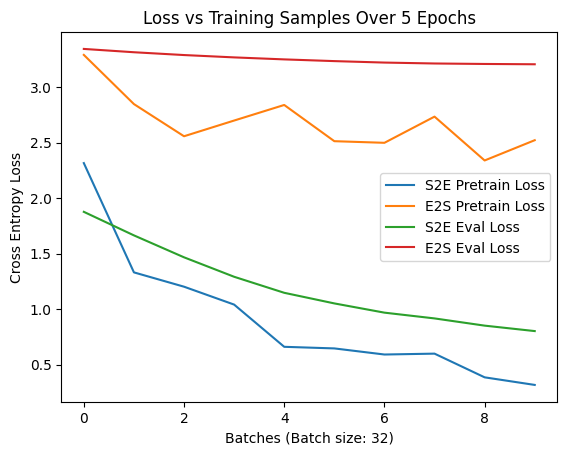

S2E Val Loss: 0.80124867649055
E2S Val Loss: 3.205059875460232


In [19]:
plt.plot(s2e_pretrain_losses, label='S2E Pretrain Loss')
plt.plot(e2s_pretrain_losses, label='E2S Pretrain Loss')
plt.plot(s2e_pre_eval_losses, label='S2E Eval Loss')
plt.plot(e2s_pre_eval_losses, label='E2S Eval Loss')
plt.title(f'Loss vs Training Samples Over {EPOCHS} Epochs')
plt.xlabel(f'Batches (Batch size: {BATCH_SIZE})')
plt.ylabel(f'Cross Entropy Loss')
plt.legend()
plt.show()

print(f'S2E Val Loss: {s2e_pre_eval_losses[-1]}')
print(f'E2S Val Loss: {e2s_pre_eval_losses[-1]}')

In [27]:
test_inputs = [
        'Detect tags: The man from Norway walked his dog in the park.',
        'Detect tags: One year, a castle appeared upon the hill outside Bath.',
        'Detect tags: alan shearer was from newcastle. He played football there.',
        'Detect tags: Alan Shearer was from Newcastle. He played football there.',
        'Detect tags: Everybody knew that apple increased their prices, even bill.',
        'Detect tags: Everybody knew that Apple increased their prices, even Bill.'
        ]

encoded_inputs = tokenizer(
        test_inputs,
        padding='max_length',
        truncation=True,
        max_length=MODEL_MAX_LENGTH,
        return_tensors='pt'
        )

encoded_outputs = s2e.generate(input_ids=encoded_inputs.input_ids.to(device), max_length=MODEL_MAX_LENGTH)
pprint(tokenizer.batch_decode(encoded_outputs, skip_special_tokens=True))

['Norway | location',
 'Bath | location',
 'alan shearer | person',
 'Alan Shearer | person',
 '',
 '']


Consider how to prepend NER Tag to synthetic sample

In [28]:
S2E_LEARNING_RATE = 1e-4
E2S_LEARNING_RATE = 1e-4
EPOCHS = 2

s2e_train_losses = []
e2s_train_losses = []

s2e_val_losses = []
e2s_val_losses = []

prefix_ids = tokenizer(PREFIX, return_tensors='pt').input_ids
batch_idxs = [list(range(len(s2e_train)))[i:i+BATCH_SIZE] for i in range(0, len(s2e_train), BATCH_SIZE)]

# TODO: Work out way to iterate over each dataset individually for different sized S and Q datasets
# Train model
for epoch in range(EPOCHS):
    # Tell PyTorch the model is training
    s2e.train()
    e2s.train()

    # Shuffle datasets
    s2e_train = s2e_train.shuffle(seed=42)
    e2s_train = e2s_train.shuffle(seed=42)

    s2e_running_loss = 0
    e2s_running_loss = 0

    # iterate over each mini_batch of BATCH_SIZE
    for idxs in (pbar := tqdm(batch_idxs)):
        pbar.set_description(f'Epoch {epoch} training')
        # Fetch current batch
        s2e_batch = s2e_train.select(idxs)
        e2s_batch = e2s_train.select(idxs)
        
        # Run S Cycle - Update e2s optimiser with reconstruction loss L(S, S')
        s_loss = cycle(s2e_batch['input_ids'], s2e_batch['label_ids'], s2e, e2s, prefix_ids)
        s2e_running_loss += s_loss.item()
        s_loss.backward()
        e2s_optimiser.step()

        # Run E Cycle - Update s2e optimiser with reconstruction loss L(Q, Q')
        e_loss = cycle(e2s_batch['input_ids'], e2s_batch['label_ids'], e2s, s2e, prefix_ids)
        e2s_running_loss += e_loss.item()
        e_loss.backward()
        s2e_optimiser.step()

    s2e_train_losses.append(s2e_running_loss / len(batch_idxs))
    e2s_train_losses.append(e2s_running_loss / len(batch_idxs))

    s2e_val_losses.append(evaluate(s2e, s2e_val))
    e2s_val_losses.append(evaluate(e2s, e2s_val))

    print(f'S2E Train Loss: {s2e_train_losses[-1]}')
    print(f'E2S Train Loss: {e2s_train_losses[-1]}') 
    print(f'S2E Val Loss: {s2e_val_losses[-1]}')
    print(f'E2S Val Loss: {e2s_val_losses[-1]}')    


# Clear CUDA cache and dispose of useless data
torch.cuda.empty_cache()
gc.collect()

Evaluating: 100%|██████████| 102/102 [00:07<00:00, 13.81it/s]


S2E Train Loss: 3.295902820355302
E2S Train Loss: 0.8487766739835433
S2E Val Loss: 0.3741183643978016
E2S Val Loss: 2.82584814230601


Evaluating: 100%|██████████| 102/102 [00:07<00:00, 13.42it/s]


S2E Train Loss: 2.8213072364483405
E2S Train Loss: 0.5056368951950598
S2E Val Loss: 0.36860036104917526
E2S Val Loss: 2.722697423953636


180

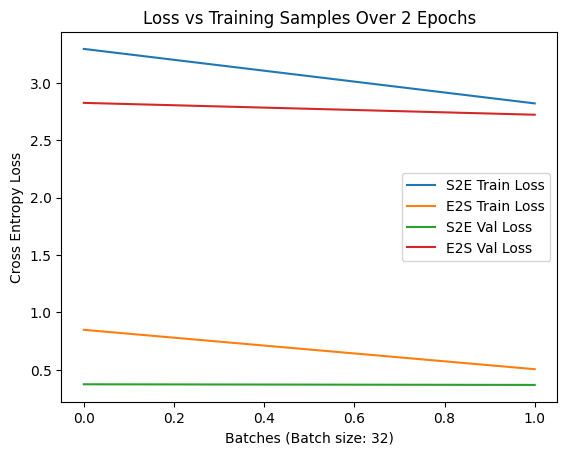

Final S2E Loss: 2.8213072364483405
Final E2S Loss: 0.5056368951950598


In [29]:
plt.plot(s2e_train_losses, label='S2E Train Loss')
plt.plot(e2s_train_losses, label='E2S Train Loss')
plt.plot(s2e_val_losses, label='S2E Val Loss')
plt.plot(e2s_val_losses, label='E2S Val Loss')
plt.title(f'Loss vs Training Samples Over {EPOCHS} Epochs')
plt.xlabel(f'Batches (Batch size: {BATCH_SIZE})')
plt.ylabel(f'Cross Entropy Loss')
plt.legend()
plt.show()

print(f'Final S2E Loss: {s2e_train_losses[-1]}')
print(f'Final E2S Loss: {e2s_train_losses[-1]}')

In [36]:
prefix = PREFIX
print(prefix)
    
s2e_test_inputs = [
        f'{prefix}The man from Bath walked his dog in the park.',
        f'{prefix}One year, a castle appeared upon the hill outside of Bath.',
        f'{prefix}alan shearer was from newcastle. He played football there.',
        f'{prefix}Alan Shearer was from Newcastle. He played football there.',
        f'{prefix}Everybody knew that apple increased their prices, even bill.',
        f'{prefix}Everybody knew that Apple increased their prices, even Bill.'
        ]

s2e_encoded_inputs = tokenizer(
        s2e_test_inputs,
        padding='max_length',
        truncation=True,
        max_length=MODEL_MAX_LENGTH,
        return_tensors='pt'
        )

s2e_encoded_outputs = s2e.generate(input_ids=s2e_encoded_inputs.input_ids.to(device), attention_mask=s2e_encoded_inputs.attention_mask.to(device), max_length=MODEL_MAX_LENGTH)
pprint(tokenizer.batch_decode(s2e_encoded_outputs, skip_special_tokens=True))

Detect tags: 
['Bath | location',
 '',
 'alan shearer | person | newcastle | location',
 'Alan Shearer | person | Newcastle | location',
 'Apple | organisation',
 'Apple | organisation | Bill | person']


In [39]:
e2s_test_inputs = [
        f'{prefix}Norway {sep_token} location',
        f'{prefix}Bath {sep_token} location',
        f'{prefix}alan shearer {sep_token} person {sep_token} newcastle {sep_token} location',
        f'{prefix}Alan Shearer {sep_token} person {sep_token} Newcastle {sep_token} location',
        f'{prefix}apple {sep_token} organisation {sep_token} bill {sep_token} person',
        f'{prefix}Apple {sep_token} organisation {sep_token} Bill {sep_token} person'
        ]

e2s_encoded_inputs = tokenizer(
        e2s_test_inputs,
        padding='max_length',
        truncation=True,
        max_length=MODEL_MAX_LENGTH,
        return_tensors='pt'
        )

#print(e2s_encoded_inputs.input_ids)

e2s_encoded_outputs = e2s.generate(input_ids=e2s_encoded_inputs.input_ids.to(device), max_length=MODEL_MAX_LENGTH)
decoded_e2s = tokenizer.batch_decode(e2s_encoded_outputs, skip_special_tokens=True)
# pprint(list(zip(e2s_test_inputs, decoded_e2s)))
pprint(decoded_e2s)

['Norway 0 0 0 0 0 0',
 'Bath 3 1 1 1 1 1 1 1 1 1 1',
 "alan shearer, newcastle's spokesman, said the spokesman for the spokesman "
 'said the spokesman said the spokesman had not commented on the situation.',
 'Alan Shearer (Typs) 0-1',
 'apple vs bill',
 "Apple said it had a'stinkering' with Bill, a'stinker' of the'stinkering' of "
 "the'stinkering' of the'stinkering'."]
